
# Integer Knapsack


## Background

Given a set of items, determine how many items to put in the knapsack to maximize their summed value.

#### Define:

- $x_i$ is the number of items from each type.

- $v_i$ is the value of each item.

- $w_i$ is the weight of each item.

- $D$ is the range of $x$.

Find $x$ that maximizes the value: $\begin{aligned}
\max_{x_i \in D} \Sigma_i v_i x_i\\
\end{aligned}$

and constrained by the weight: $\begin{aligned}
\Sigma_i w_i x_i = C
\end{aligned}$


## Problem Versions


**Binary Knapsack**

Range: $D = \{0, 1\}$

**Integer Knapsack**

Range: $D = [0, b]$


## Knapsack with integer variables and inequality constraint


### Define the optimization problem

In [1]:
import numpy as np
import pyomo.environ as pyo


def define_knapsack_model(weights, values, max_weight, item_bound):
    model = pyo.ConcreteModel("knapsack")
    num_items = len(weights)

    model.x = pyo.Var(
        range(num_items), domain=pyo.NonNegativeIntegers, bounds=(0, item_bound)
    )

    x_variables = np.array(list(model.x.values()))

    model.weight_constraint = pyo.Constraint(expr=x_variables @ weights <= max_weight)

    model.value = pyo.Objective(expr=x_variables @ values, sense=pyo.maximize)

    return model

### Initialize the model with parameters

In [2]:
knapsack_model = define_knapsack_model(
    weights=[2, 3], values=[3, 5], max_weight=12, item_bound=3
)

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):

In [3]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=5, penalty_energy=20.0)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [4]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=0.7)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [5]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=knapsack_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [6]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [7]:
from classiq import write_qmod

write_qmod(qmod, "knapsack_integer")

In [8]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/6fce0f2c-7f0d-4136-a312-9d130170fe35?version=0.45.0.dev0%2Bcf1b9b7ccc


We now solve the problem by calling the `execute` function on the quantum program we have generated:

In [9]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

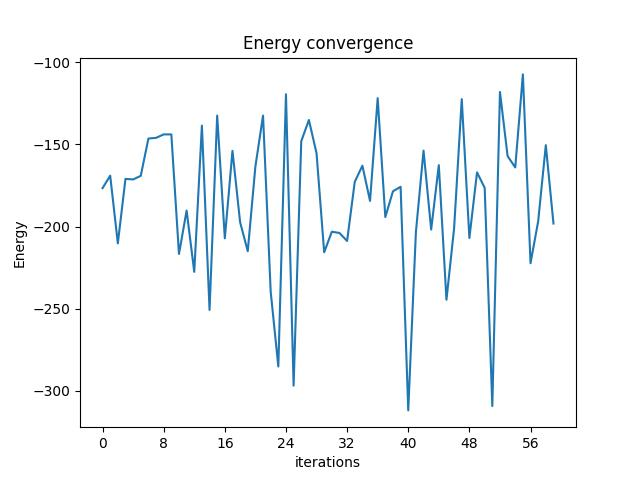

In [10]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

# Optimization Results

We can also examine the statistics of the algorithm:

In [11]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    knapsack_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=False).head(5)

,probability,cost,solution,count
51,0.006,18.0,"[1, 3]",6
127,0.002,15.0,"[0, 3]",2
54,0.006,14.0,"[3, 1]",6
55,0.006,13.0,"[1, 2]",6
25,0.011,11.0,"[2, 1]",11


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

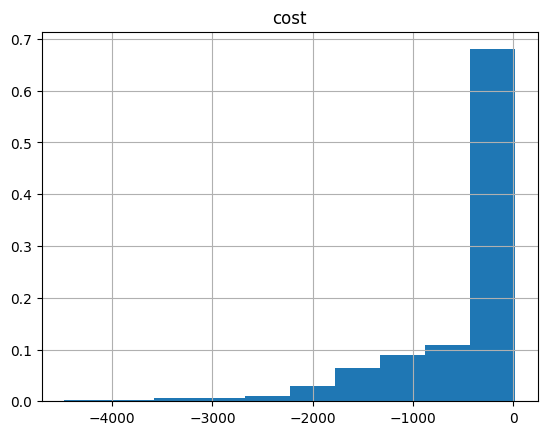

In [12]:
optimization_result.hist("cost", weights=optimization_result["probability"])

Lastly, we can compare to the classical solution of the problem:

In [13]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(knapsack_model)

knapsack_model.display()

Model knapsack

  Variables:
    x : Size=2, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   3.0 :     3 : False : False : NonNegativeIntegers
          1 :     0 :   2.0 :     3 : False : False : NonNegativeIntegers

  Objectives:
    value : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :  19.0

  Constraints:
    weight_constraint : Size=1
        Key  : Lower : Body : Upper
        None :  None : 12.0 :  12.0
